# Using a NN classifier to generate a likelihood function

In this notebook, I will implement the approach described in the paper linked below to generate a likelihood function for measurements sampled from a Gaussian distribution. I will compare the result to the exact likelihood function and assess the results.

Primary reference: https://arxiv.org/pdf/1903.04057.pdf

In [1]:
import numpy as np
import math
import numba
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz

Consider a gaussian pdf with parameters $\mu$ and $\sigma$. A single measurement $x$ drawn from this distribution is distributed according to the following density:

### $p(x|\mu, \sigma) = \frac{1}{\sqrt{2 \pi}\sigma} \exp\left[\frac{-(x-\mu)^2}{2\sigma^2}\right]$

This density can be used to exactly evaluate the negative log likelihood (NLL) from a set of measurements:

### $NLL(\mu, \sigma | \vec{x}) \propto \sum_i \left[\frac{\left(x_i-\mu\right)^2}{2\sigma^2} + \ln(\sigma)\right]$.

In the above, additive constants to the NLL have been omitted because they do not affect the optimization. 

For a concrete example, consider a distribution with parameters $(\mu, \sigma) = (3, 5)$. I will draw 1000 measurements from this distribution and visualize the exact two dimensional NLL.

In [2]:
@numba.njit
def eval_gaus(x, mu, sig):
    return 1/math.sqrt(2*math.pi)/sig*np.exp(-(x-mu)**2/(2*sig**2))

@numba.njit
def gaus_nll(mu, sig, x_i):
    return ((x_i - mu)**2/(2*sig**2) + math.log(sig)).sum()

In [3]:
n_measurements = 1000
test_mu = -0.8
test_sig = 3.5
x_i = test_sig*np.random.randn(n_measurements) + test_mu

Now I'll visualize the measurements using a histogram and overlay the exact distribution

In [4]:
plt.rcParams['figure.figsize'] = 9, 6

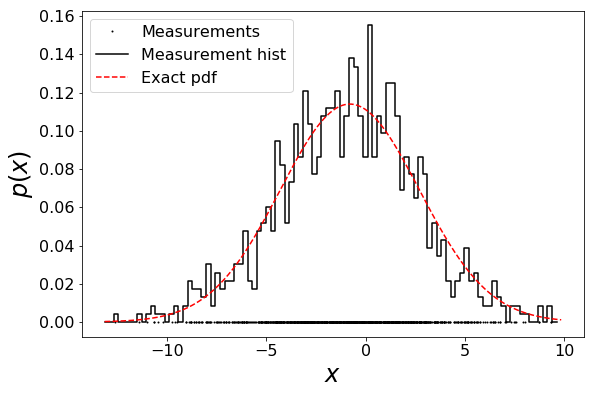

In [5]:
meas_hist, hist_bins = np.histogram(x_i, bins=np.linspace(x_i.min() - 0.5, x_i.max()+0.5, 100))
meas_hist = meas_hist/np.trapz(meas_hist, 0.5*(hist_bins[:-1]+hist_bins[1:]))
eval_xs = np.linspace(x_i.min() - 0.5, x_i.max() + 0.5, 10000)
plt.plot(x_i, np.zeros_like(x_i), 'ko', label='Measurements', markersize=1)
plt.step(hist_bins[:-1], meas_hist, where='post', color='black', label='Measurement hist')
plt.plot(eval_xs, eval_gaus(eval_xs, test_mu, test_sig), 
         'r--', label='Exact pdf')

plt.xlabel('$x$', fontsize=24)
plt.ylabel('$p(x)$',fontsize=24)
plt.gca().tick_params(labelsize=16)
plt.legend(fontsize=16)

Now I will evaluate the NLL given these measurements. I will explore around the mean and standard deviation of the dataset.

In [6]:
@numba.njit
def nll_scan(x_i, means, stds):
    output = np.empty((len(stds), len(means)),
                      dtype=np.float64)
    
    for i, std in enumerate(stds):
        for j, mean in enumerate(means):
            output[i, j] = gaus_nll(mean, std, x_i)
            
    return output

In [7]:
gaus_nll(test_mu, 9, x_i)

2271.9242164595003

In [8]:
plt.rcParams['figure.figsize'] = 6, 6

In the asymptotic approximation of a normally distributed posterior distribution, confidence contours can be approximated by considering the critical values of a $\chi^2$ distribution with $n$ degrees of freedom (see, for example, wikipedia: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Interval).

In this test, $n$ is equal to 2. So, I should consider a $\chi^2$ distribution with 2 degrees of freedom. Changes of one unit in the NLL are equivalent to changes of 2 units in the $\chi^2$. So, the approximate 68%, 90%, and 95% intervals are obtained by finding where the NLL changes by 2.28/2, 4.61/2, 5.99/2, respectively (see, e.g., https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_%CF%872_values_vs_p-values).

In [9]:
def plot_nll_scan(x_i, nll_scan_func, gridsize=200, title=None):
    meas_mean = x_i.mean()
    meas_std = x_i.std()

    err_mean = meas_std/math.sqrt(len(x_i))
    
    mean_range = np.linspace(meas_mean - 4.5*err_mean, meas_mean + 4.5*err_mean, gridsize)
    std_range = np.linspace(meas_std*0.85, meas_std*1.15, gridsize)

    nll_map = nll_scan_func(x_i, mean_range, std_range)

    plt.pcolormesh(mean_range, std_range, nll_map.min() - nll_map,
                   vmin=-10, vmax=0)

    plt.xlabel("$\mu$", fontsize=24)

    plt.ylabel("$\sigma$", fontsize=24)

    plt.plot([test_mu], [test_sig], 'k*', label='truth')

    best_fit_std_i, best_fit_mu_i = np.unravel_index(np.argmin(nll_map), nll_map.shape)

    plt.plot([mean_range[best_fit_mu_i]], [std_range[best_fit_std_i]], 'b*', label='best fit')
#     plt.plot([meas_mean], [meas_std], 'm*', label=r'$\left[\langle x\rangle, \mathrm{stdev}(x)\right]$')


    plt.contour(mean_range, std_range, nll_map - nll_map.min(), [2.28/2, 4.61/2, 5.99/2], 
                colors=['blue', 'blue', 'blue'], linestyles=['solid', 'dashed', 'dotted'])

    plt.gca().tick_params(labelsize=16)
    
    if title is not None:
        plt.title(title, fontsize=24)
    
    plt.legend(fontsize=16, loc='upper right')
    
    return nll_map, mean_range, std_range

CPU times: user 581 ms, sys: 8.96 ms, total: 590 ms
Wall time: 589 ms


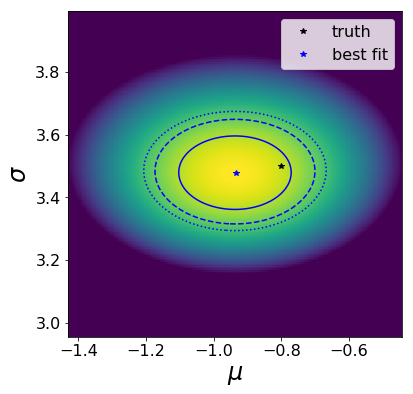

In [10]:
%%time
nll_map, mean_range, std_range = plot_nll_scan(x_i, nll_scan)

In [11]:
# use finite differences to approximate the hessian matrix
# for 2d NLL
def approx_hess(nll_map, i_step, j_step):
    delta_chi = 2*(nll_map - nll_map.min())
    max_i, max_j = np.unravel_index(np.argmin(nll_map), nll_map.shape)
    
    hess = np.empty((2,2))
    
    hess[0, 0] = 0.5/i_step**2*(delta_chi[max_i+1, max_j] + delta_chi[max_i-1, max_j])
    hess[1, 1] = 0.5/j_step**2*(delta_chi[max_i, max_j+1] + delta_chi[max_i, max_j-1])
    hess[0, 1] = 0.125/i_step/j_step*(delta_chi[max_i+1, max_j+1] + delta_chi[max_i-1, max_j-1]
                                      -delta_chi[max_i-1, max_j+1] - delta_chi[max_i+1, max_j-1])
    hess[1, 0] = hess[0, 1]
    
    return hess

In [12]:
def print_uncertainties(nll_map, mean_range, std_range):
    test_hess = approx_hess(nll_map, std_range[1] - std_range[0], mean_range[1] - mean_range[0])
    print('hessian matrix:')
    print(test_hess)
    print('covariance matrix:')
    cov = np.linalg.inv(test_hess)
    print(cov)
    print(f'mean error from approximate hess {math.sqrt(cov[1, 1]):.2f}')
    print(f'expected mean error is {test_sig/math.sqrt(len(x_i)):.2f}')
    # also do quick error from delta NLL = 0.5, assuming no correlation
    # (profile likelihood would be along best sigma fit slice)
    best_fit_std_i, best_fit_mu_i = np.unravel_index(np.argmin(nll_map), nll_map.shape)
    
    best_std_slice = nll_map[best_fit_std_i]
    one_sig_mean_i = np.argwhere(best_std_slice - best_std_slice.min() <= 1.0/2)[-1, 0]
    approx_mean_std = (mean_range[one_sig_mean_i] - mean_range[best_fit_mu_i])
    print(f'approximate mean error from NLL contour assuming no mu-sig correlation: {approx_mean_std:.2f}')
    

In [13]:
print_uncertainties(nll_map, mean_range, std_range)

hessian matrix:
[[ 1.64906718e+02 -1.18100530e-01]
 [-1.18100530e-01  8.26395367e+01]]
covariance matrix:
[[6.06404055e-03 8.66614735e-06]
 [8.66614735e-06 1.21007579e-02]]
mean error from approximate hess 0.11
expected mean error is 0.11
approximate mean error from NLL contour assuming no mu-sig correlation: 0.10


### Alright. Everything appears to be working

# Step 2: Train an artificial neural network to generate a likelihood function. I will essentially follow the algorithm from the paper cited at the beginning of this notebook.  

### Network input features: $x$, $\mu$, $\sigma$. 
### Network output: d. 
The ouptut d is essentially a classification score; whether $x$, $\mu$, $\sigma$ were more likely sampled from the joint distribution $p(x, \mu, \sigma)$ or the combined marginal distributions $p(x)p(\mu, \sigma)$. 

With only three input features, I should be able to generate a large amount of training data.  

I will sample $\mu$ and $\sigma$ uniformly from the ranges [-10, 10] and [0.1, 20], respectively.

In [14]:
mu_min = -10
mu_max = 10
sig_min = 0.1
sig_max = 20
n_samples = 2000000
n_validation = int(n_samples/10)

In [15]:
def simulate(n):
    ''' returns xs, mus, sigs, mu_primes, sig_primes
    each of length n
    '''
    mus = np.random.uniform(mu_min, mu_max, n)
    sigs = np.random.uniform(sig_min, sig_max, n)
    xs = np.random.randn(n)*sigs + mus
    
    mu_primes = np.random.uniform(mu_min, mu_max, n)
    sig_primes = np.random.uniform(sig_min, sig_max, n)
    
    return xs, mus, sigs, mu_primes, sig_primes

### Build a basic feed forward NN with 4 hidden layers

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation

In [17]:
def build_basic_model():
    model = keras.models.Sequential()
    model.add(Dense(units=24, activation='elu',
                    input_shape=(3,)))
    model.add(Dense(units=24, activation='elu'))
    model.add(Dense(units=24, activation='elu'))
    model.add(Dense(units=12, activation='elu'))
    model.add(Dense(units=12, activation='elu'))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [18]:
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
______________________________________________________

In [19]:
def prepare_training_tensor(n_samples):
    ''' returns training tensor and associated labels'''
    x, mu, sig, mu_p, sig_p = simulate(n_samples)
    tensor = np.empty((2*n_samples, 3), dtype=np.float32)
    
    class_1 = tensor[:n_samples, :]
    class_1[:, 0] = x
    class_1[:, 1] = mu
    class_1[:, 2] = sig
    
    class_0 = tensor[n_samples:, :]
    class_0[:, 0] = x
    class_0[:, 1] = mu_p
    class_0[:, 2] = sig_p 
    
    labels = np.array([[1]]*n_samples + [[0]]*n_samples)
    
    return tensor, labels

In [20]:
training_samples, training_labels = prepare_training_tensor(n_samples)
validation_samples, validation_labels = prepare_training_tensor(n_validation)

### normalize the inputs 

In [21]:
feature_means = np.mean(training_samples, axis=0)
feature_stds = np.std(training_samples, axis=0)

In [22]:
training_samples[:] = (training_samples - feature_means)/feature_stds
validation_samples[:] = (validation_samples - feature_means)/feature_stds

### Set up training parameters and then train the model

In [23]:
initial_rate = 0.005
patience = 10
batch_size = 10000

In [24]:
opt = keras.optimizers.Adam(learning_rate=initial_rate)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
def learning_scheduler(epoch):
    if epoch < 10:
        return initial_rate
    else:
        # taken/adpated from https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
        return initial_rate * tf.math.exp(0.025*(10-epoch))

# print LR callback from
# https://www.tensorflow.org/tutorials/distribute/keras#keras_api
class PrintLR(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            print('\nLearning rate for epoch {} is {}'.format(
                epoch + 1,
                model.optimizer.lr.numpy()))
            
callbacks = []
callbacks.append(keras.callbacks.LearningRateScheduler(
    learning_scheduler))
callbacks.append(keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, restore_best_weights=True))
callbacks.append(PrintLR())

In [26]:
history = model.fit(x=training_samples, y=training_labels,
                    batch_size=batch_size, epochs=200,
                    callbacks=callbacks, 
                    validation_data=(validation_samples, 
                                     validation_labels),
                    shuffle=True)

Train on 4000000 samples, validate on 400000 samples
Epoch 1/200
3840000/4000000 [===========================>..] - ETA: 0s - loss: 0.5868 - accuracy: 0.6637
Learning rate for epoch 1 is 0.004999999888241291
4000000/4000000 [==============================] - 2s 1us/sample - loss: 0.5863 - accuracy: 0.6640 - val_loss: 0.5733 - val_accuracy: 0.6729
Epoch 2/200
3900000/4000000 [============================>.] - ETA: 0s - loss: 0.5723 - accuracy: 0.6728
Learning rate for epoch 2 is 0.004999999888241291
4000000/4000000 [==============================] - 1s 0us/sample - loss: 0.5723 - accuracy: 0.6728 - val_loss: 0.5715 - val_accuracy: 0.6739
Epoch 3/200
3980000/4000000 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.6732
Learning rate for epoch 3 is 0.004999999888241291
4000000/4000000 [==============================] - 1s 0us/sample - loss: 0.5716 - accuracy: 0.6731 - val_loss: 0.5711 - val_accuracy: 0.6742
Epoch 4/200
3960000/4000000 [============================>.

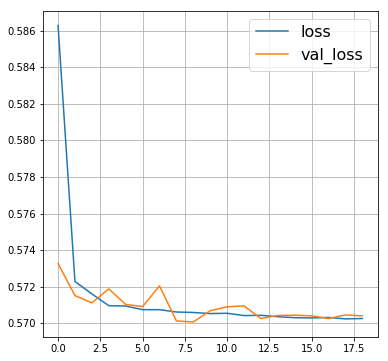

In [27]:
for quantity, vals in history.history.items():
    if (quantity != 'lr' and not quantity.endswith('accuracy')):
        plt.plot(vals, label=quantity)
plt.legend(fontsize=16)
plt.grid()

### It learned something... let's see if it works

In [28]:
def NN_classify(mu, sig, x_i, 
                model=model, mean=feature_means, std=feature_stds,
                max_batch_size=100000):
    tensor = np.empty((len(x_i), 3), dtype=np.float32)
    tensor[:, 0] = x_i
    tensor[:, 1] = mu
    tensor[:, 2] = sig
    tensor[:] = (tensor-feature_means)/feature_stds
    
    batch_size = min(len(tensor), max_batch_size)
    
    return model.predict(tensor, batch_size=batch_size)[:, -1]

def NN_nll(mu, sig, x_i, 
            model=model, mean=feature_means, std=feature_stds):
    ''' returns the NLLH evaluated using the neural network'''
    ds = NN_classify(mu, sig, x_i,
                     model, feature_means, feature_stds)

    return (-np.log(ds/(1-ds))).sum()

def NN_nll_batch(mus, sigs, x_i,
                 model=model, mean=feature_means, std=feature_stds,
                 max_batch_size=100000):
    ''' returns the neural net NLL 
        for each hypothesized mu, sig in mus and sigs
        outputs a 2d array of the NLL values.
        
        evaluation for mu_i, sig_j is located at output_array[j, i]
    '''    
    x_i = np.copy(np.atleast_1d(x_i))
    mus = np.copy(np.atleast_1d(mus))
    sigs = np.copy(np.atleast_1d(sigs))
    
    # apply normalization before building the tensor
    for i, arr in enumerate([x_i, mus, sigs]):
        arr[:] = (arr - feature_means[i])/feature_stds[i]
    
    tensor = np.empty((len(x_i)*len(mus)*len(sigs), 3), dtype=np.float32) 
    tensor[:, 0] = np.tile(x_i, len(mus)*len(sigs))
    tensor[:, 1] = np.tile(np.repeat(mus, len(x_i)), len(sigs))
    tensor[:, 2] = np.repeat(sigs, len(x_i)*len(sigs))
        
    batch_size = min(len(tensor), max_batch_size)
    
    ds = model.predict(tensor, batch_size=batch_size)[:, -1]
    
    ds = ds.reshape((len(sigs), len(mus), len(x_i)))
    
    return (-np.log(ds/(1-ds))).sum(axis=-1)
    
    
def NN_nll_scan(x_i, means, stds):
    # just a wrapper now... used to be more complicated
    return NN_nll_batch(means, stds, x_i)

### Compare the NLL map from the exact likelihood to the NLL map from the neural network

In [29]:
plt.rcParams['figure.figsize'] = 12, 6

CPU times: user 3.97 s, sys: 347 ms, total: 4.31 s
Wall time: 2.42 s


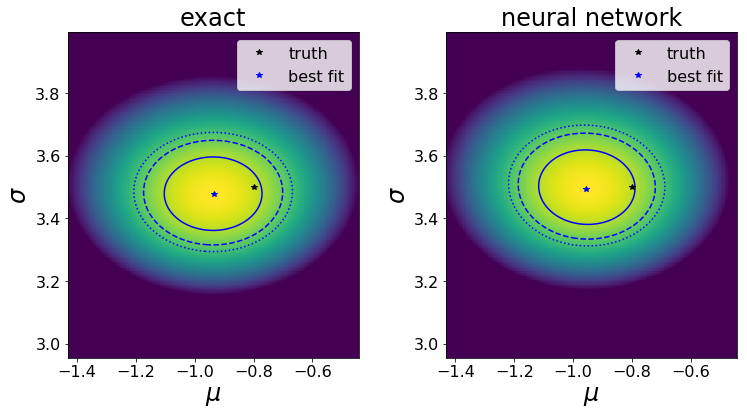

In [30]:
%%time
plt.subplots_adjust(wspace=0.3)
plt.subplot(121)
nll_map, mean_range, sig_range = plot_nll_scan(x_i, nll_scan, title='exact')
plt.subplot(122)
NN_nll_map, NN_mean_range, NN_sig_range = plot_nll_scan(x_i, NN_nll_scan, title='neural network')

### Measure uncertainties, see how well we did.

Exact uncertainties:

In [31]:
print_uncertainties(nll_map, mean_range, sig_range)

hessian matrix:
[[ 1.64906718e+02 -1.18100530e-01]
 [-1.18100530e-01  8.26395367e+01]]
covariance matrix:
[[6.06404055e-03 8.66614735e-06]
 [8.66614735e-06 1.21007579e-02]]
mean error from approximate hess 0.11
expected mean error is 0.11
approximate mean error from NLL contour assuming no mu-sig correlation: 0.10


Neural net uncertainties:

In [32]:
print_uncertainties(NN_nll_map, NN_mean_range, NN_sig_range)

hessian matrix:
[[164.48176808   2.92869944]
 [  2.92869944  88.90906382]]
covariance matrix:
[[ 0.00608327 -0.00020039]
 [-0.00020039  0.01125405]]
mean error from approximate hess 0.11
expected mean error is 0.11
approximate mean error from NLL contour assuming no mu-sig correlation: 0.11


In [33]:
def get_best_fit_params(nll_map, mean_bins, sig_bins):
    best_fit_inds = np.unravel_index(np.argmin(nll_map), nll_map.shape)
    best_fit_mu = mean_bins[best_fit_inds[1]]
    best_fit_sig = sig_bins[best_fit_inds[0]]
    
    return best_fit_mu, best_fit_sig

### It appears to have worked quite well

Now I'll plot the histogram with the best fit using the neural net likelihood and the best fit using the exact likelihood

exact fit params: (-0.93, 3.48)
neural net fit params: (-0.95, 3.49)


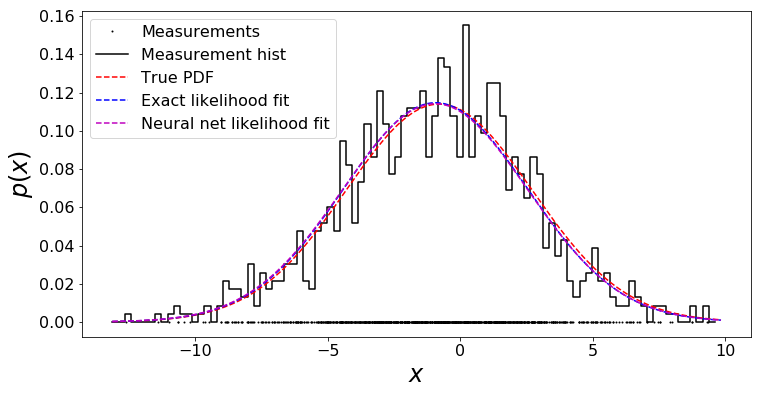

In [34]:
plt.plot(x_i, np.zeros_like(x_i), 'ko', label='Measurements', markersize=1)

plt.step(hist_bins[:-1], meas_hist, where='post', color='black', label='Measurement hist')

plt.plot(eval_xs, eval_gaus(eval_xs, test_mu, test_sig), 
         'r--', label='True PDF')

exact_fit_mu, exact_fit_sig = get_best_fit_params(nll_map, mean_range, sig_range)

plt.plot(eval_xs, eval_gaus(eval_xs, exact_fit_mu, exact_fit_sig), 
         'b--', label='Exact likelihood fit')

nn_fit_mu, nn_fit_sig = get_best_fit_params(NN_nll_map, NN_mean_range, NN_sig_range)

plt.plot(eval_xs, eval_gaus(eval_xs, nn_fit_mu, nn_fit_sig), 
         'm--', label='Neural net likelihood fit')

plt.xlabel('$x$', fontsize=24)
plt.ylabel('$p(x)$',fontsize=24)
plt.gca().tick_params(labelsize=16)
plt.legend(fontsize=16)

print(f'exact fit params: ({exact_fit_mu:.2f}, {exact_fit_sig:.2f})')
print(f'neural net fit params: ({nn_fit_mu:.2f}, {nn_fit_sig:.2f})')

### try to generate something like $p(x|\mu^{\textrm{NN}}, \theta^{\textrm{NN}})$ using the neural net classifier. The $\textrm{NN}$ superscripts indicate best-fit quantities from the NN likelihood scan.

What I can get from the classifier is $\frac{p(x|\theta)}{p(x)}$. The $p(x)$ term in the denominator is affected by how the training dataset was generated, specifically the relative numbers of different $x$ values appearing in the training set. This factor is irrelevant for parameter extraction, where the measurements $x$ are fixed for all values of $\theta$ under consideration. However, in trying to compare the NN output to a known pdf $p(x, \theta)$, $x$ is varying and therefore the factor is relavent. The NN output will only be proportional to the desired PDF when evaluated over $x$ values with equal representation in the training dataset, i.e. $x$ values with constant, or very similar, $p(x)$. I will histogram the $x$ values in my training set and then demonstrate that my trained NN can reproduce the Gaussian probability density in regions where $p(x)$ is flat.  

I will also parameterize $p(x)$ and use it as a correction to obtain $p(x, \theta)$ from the NN output.

In [35]:
from scipy.interpolate import UnivariateSpline

(-30, 30)

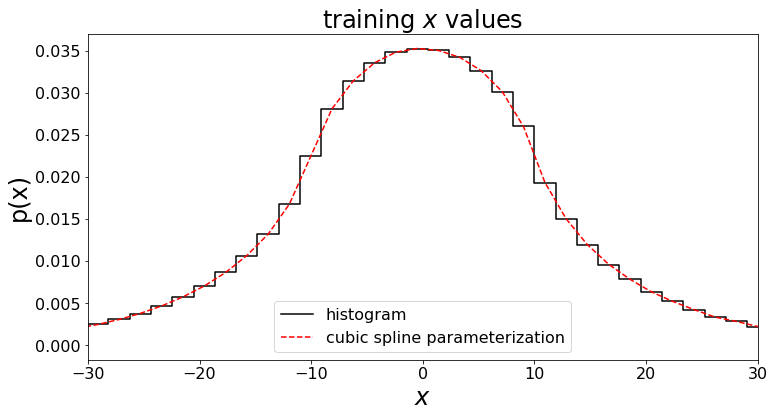

In [36]:
training_xs = feature_stds[0]*training_samples[:, 0] + feature_means[0]
min_x = training_xs.min()
max_x = training_xs.max()
training_bins = np.linspace(min_x - 0.5, max_x+0.5, 100)

bin_cents = 0.5*(training_bins[:-1] + training_bins[1:])

training_x_hist, training_bins = np.histogram(training_xs, 
                                              bins=training_bins)

hist_std = np.sqrt(np.where(training_x_hist > 0, training_x_hist, 1))

norm = np.trapz(training_x_hist, bin_cents)

training_x_hist = training_x_hist / norm
hist_std = hist_std / norm

p_x = UnivariateSpline(bin_cents, training_x_hist, w=1.0/hist_std)

plt.step(training_bins[:-1], training_x_hist, where='post', color='k', label='histogram')
plt.plot(bin_cents, p_x(bin_cents), 'r--', label='cubic spline parameterization')
plt.title('training $x$ values', fontsize=24)
plt.ylabel('p(x)', fontsize=24)
plt.xlabel('$x$', fontsize=24)
plt.gca().tick_params(labelsize=16)
plt.legend(fontsize=16)
plt.xlim(-30, 30)

### I will use the above as an estimate of $p(x)$; the NN likelihood is then $\frac{d}{1-d}\cdot p(x)$

CPU times: user 74.8 ms, sys: 19.8 ms, total: 94.6 ms
Wall time: 95.8 ms


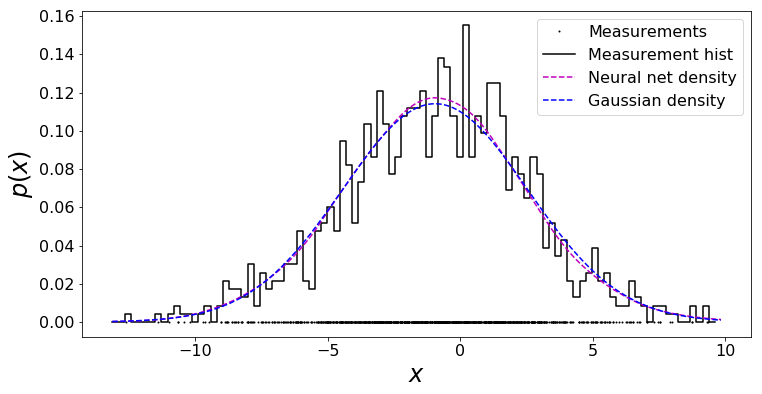

In [37]:
%%time
eval_ds = NN_classify(nn_fit_mu, nn_fit_sig, eval_xs)
nn_p = eval_ds/(1-eval_ds)*p_x(eval_xs)

# normalize
norm = np.trapz(nn_p, eval_xs)
nn_p = nn_p / norm

plt.plot(x_i, np.zeros_like(x_i), 'ko', label='Measurements', markersize=1)
plt.step(hist_bins[:-1], meas_hist, where='post', color='black', label='Measurement hist')
plt.plot(eval_xs, nn_p, 'm--', label='Neural net density')
plt.plot(eval_xs, eval_gaus(eval_xs, nn_fit_mu, nn_fit_sig), 'b--', label='Gaussian density')

plt.xlabel('$x$', fontsize=24)
plt.ylabel('$p(x)$',fontsize=24)
plt.gca().tick_params(labelsize=16)
plt.legend(fontsize=16)

Here the NN density and the Gaussian density agree quite well (although not perfectly).

### Now I'll look at a few NN and exact PDFs, with and without the $p(x)$ correction.

In [38]:
def get_pdfs(eval_xs, mu, sig, model=model, p_of_x=p_x):
    ''' returns the exact pdf, the uncorrected NN pdf, 
    and the corrected NN pdf, each evaluated at eval_xs'''
    exact_pdf = eval_gaus(eval_xs, mu, sig)
    
    NN_ds = NN_classify(mu, sig, eval_xs)
    uncor_NN_pdf = NN_ds/(1-NN_ds)
    
    cor_NN_pdf = uncor_NN_pdf*p_of_x(eval_xs)
    
    return exact_pdf, uncor_NN_pdf, cor_NN_pdf

def plot_pdfs(eval_xs, mu, sig, title=None):    
    exact, uncor, cor = get_pdfs(eval_xs, mu, sig)
    
    # manually normalize the NN PDFs
    norm = np.trapz(uncor, eval_xs)
    uncor = uncor / norm
    
    norm = np.trapz(cor, eval_xs)
    cor = cor / norm
    
    plt.plot(eval_xs, exact, 'k--', label='Gaussian pdf')
    plt.plot(eval_xs, uncor, 'r--', label='uncorrected NN pdf')
    plt.plot(eval_xs, cor, 'b--', label='corrected NN pdf')
    
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$p(x)$', fontsize=16)
    
    plt.legend(fontsize=14)
    
    if title is not None:
        plt.title(title, fontsize = 24)
    
    plt.gca().tick_params(labelsize=16)
    
    plt.xlim(mu - 5*sig, mu+5*sig)

In [39]:
plt.rcParams['figure.figsize'] = 9, 4

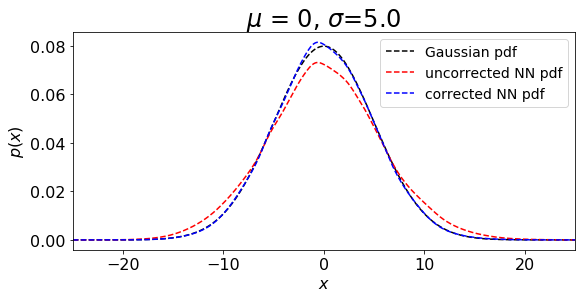

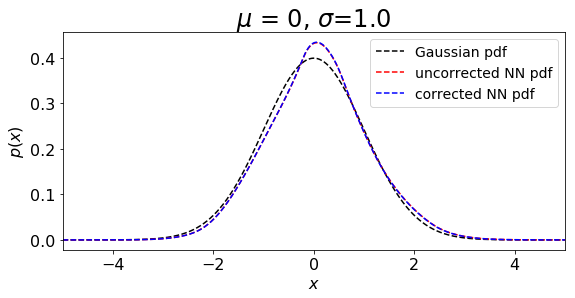

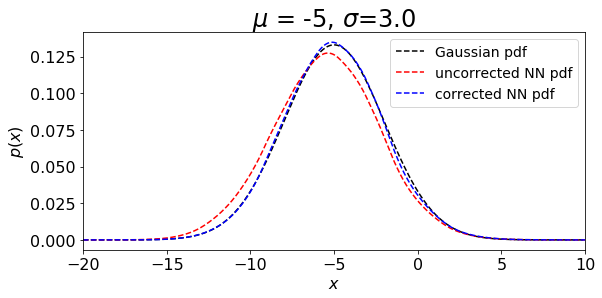

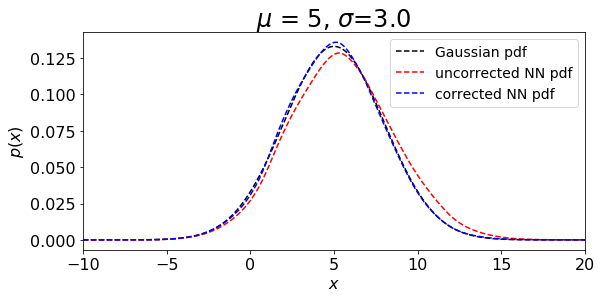

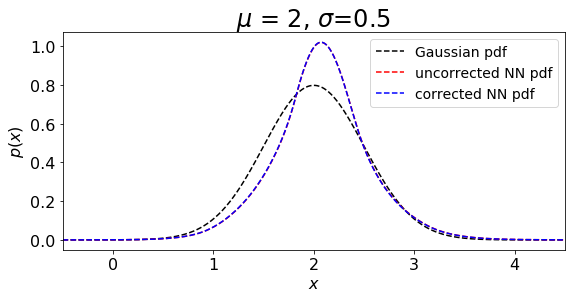

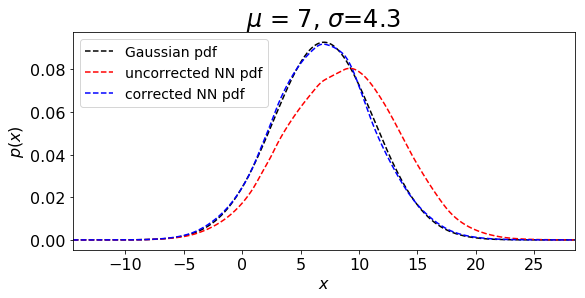

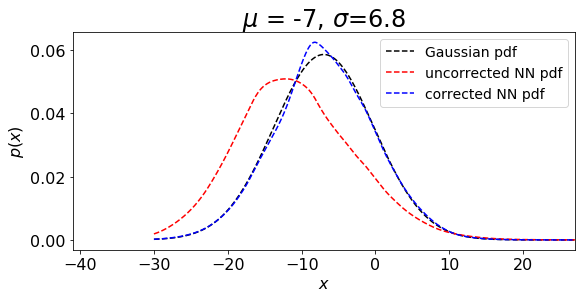

In [40]:
pdf_eval_xs = np.linspace(-30, 30, 10000)
mu_sigs = [(0, 5), (0, 1), (-5, 3), (5, 3), (2, 0.5), (7, 4.3), (-7, 6.8)]
for mu, sig in mu_sigs:
    plot_pdfs(pdf_eval_xs, mu, sig, title=f'$\mu$ = {mu:.0f}, $\sigma$={sig:.1f}')
    plt.show()

### The corrected NN pdf agrees quite well with the the Gaussian pdf, even near the edges of the parameter range used in training. The NN pdf agrees less well with the exact pdf for tightly peaked distributions (small $\sigma$). This could likely be improved with a different network architecture.